BASELINE model and code download

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1-6jjLrLnykaz0wE1bcUcvi6Qp3_k6RGE&export=download

TEST set download

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=16-gCkIO1N-p-SigYdl7Qo2NXjPDnSNHC&export=download

In [ ]:
!unzip BASELINE.zip
!unzip reid-col780-master.zip

In [ ]:
%cd BASELINE/
!unzip model.zip

In [ ]:
!pip install timm
!pip install faiss-gpu==1.7.1  

In [6]:
import os
import time
import glob
import random
import zipfile
from itertools import chain

import timm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from model import ClassBlock, LATransformer, LATransformerTest
from utils import save_network, update_summary, get_id
from metrics import rank1, rank5, rank10, calc_map

import faiss
import numpy as np

batch_size = 2
gamma = 0.7
seed = 42

def get_device(gpu_no):
	if torch.cuda.is_available():
		torch.cuda.set_device(gpu_no)
		return torch.device('cuda:{}'.format(gpu_no))
	else:
		return torch.device('cpu')
device = get_device(0)


In [7]:
model_name ='vit_base_patch16_224'
print(model_name)
vit_large = timm.create_model(model_name, pretrained=True, num_classes=62)
vit_large= vit_large.to(device)

# Create La-Transformer
model = LATransformerTest(vit_large, lmbd=8).to(device)

# Load LA-Transformer
name = "la_with_lmbd_8"

modelfolder = './model'
save_path = os.path.join(modelfolder,name,'net_best.pth')
#save_path = "net_best.pth"
model.load_state_dict(torch.load(save_path), strict=False)
model.eval()

transform_query_list = [
    transforms.Resize((224,224), interpolation=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
transform_gallery_list = [
    transforms.Resize(size=(224,224),interpolation=3), #Image.BICUBIC
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
data_transforms = {
'query': transforms.Compose( transform_query_list ),
'gallery': transforms.Compose(transform_gallery_list),
}

image_datasets = {}
data_dir = "../reid-col780-master/data/val"

image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                          data_transforms['query'])
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                          data_transforms['gallery'])
query_loader = DataLoader(dataset = image_datasets['query'], batch_size=batch_size, shuffle=False )
gallery_loader = DataLoader(dataset = image_datasets['gallery'], batch_size=batch_size, shuffle=False)

class_names = image_datasets['query'].classes
print(len(class_names))

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def extract_feature(model,dataloaders):
    
    features =  torch.FloatTensor()
    count = 0
    idx = 0
    for data in (dataloaders):
        img, label = data
        img, label = img.to(device), label.to(device)

        output = model(img)

        n, c, h, w = img.size()
        
        count += n
        features = torch.cat((features, output.detach().cpu()), 0)
        idx += 1
    return features

# Extract Query Features
query_feature= extract_feature(model, query_loader)

# Extract Gallery Features
gallery_feature = extract_feature(model, gallery_loader)

# Retrieve labels
gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        # print(path)
        label = path.split("/")[-2]
        filename = os.path.basename(path)
        camera = filename.split('_')[0]
        labels.append(int(label))
        camera_id.append(int(camera))
    return camera_id, labels

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)

concatenated_query_vectors = []
for query in (query_feature):
   
    fnorm = torch.norm(query, p=2, dim=1, keepdim=True)*np.sqrt(14)
   
    query_norm = query.div(fnorm.expand_as(query))
    
    concatenated_query_vectors.append(query_norm.view((-1))) 

concatenated_gallery_vectors = []

for gallery in (gallery_feature):
    fnorm = torch.norm(gallery, p=2, dim=1, keepdim=True) *np.sqrt(14)
   
    gallery_norm = gallery.div(fnorm.expand_as(gallery))
    
    concatenated_gallery_vectors.append(gallery_norm.view((-1))) 

index = faiss.IndexIDMap(faiss.IndexFlatIP(10752)) # 14* 1024 --> 14336

index.add_with_ids(np.array([t.numpy() for t in concatenated_gallery_vectors]),np.array(gallery_label))

def search(query: str, k=1):
    encoded_query = query.unsqueeze(dim=0).numpy()
    top_k = index.search(encoded_query, k)
    return top_k

rank1_score = 0
rank5_score = 0
rank10_score = 0
ap = 0
count = 0
for query, label in zip(concatenated_query_vectors, query_label):
    count += 1
    label = label
    print("Query:",count)
    print("Ground Truth Label:",label)
    output = search(query, k=10)
    print("Output:",output[1])
    rank1_score += rank1(label, output) 
    rank5_score += rank5(label, output) 
    rank10_score += rank10(label, output) 
    print("Correct: {}, Total: {}, Incorrect: {}".format(rank1_score, count, count-rank1_score), end="\r")
    ap += calc_map(label, output)

print("Rank1: {}, Rank5: {}, Rank10: {}, mAP: {}".format(rank1_score/len(query_feature), 
                                                         rank5_score/len(query_feature), 
                                                         rank10_score/len(query_feature), ap/len(query_feature)))

vit_base_patch16_224


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


12
Query: 1
Ground Truth Label: 4
Output: [[12  4 12 12  4 12  4  4  4  4]]
Query: 2
Ground Truth Label: 4
Output: [[ 4  4  4  4 12 12 12 12  4 12]]
Query: 3
Ground Truth Label: 12
Output: [[12 12 12 32 12 12 12 12 12 52]]
Query: 4
Ground Truth Label: 12
Output: [[12 12 12 12 12 12 12 12  4 12]]
Query: 5
Ground Truth Label: 12
Output: [[12 12 12 12 12 12 12 12 12 32]]
Query: 6
Ground Truth Label: 12
Output: [[12 32 12 12 12 12 12 12 12 12]]
Query: 7
Ground Truth Label: 17
Output: [[17 17 17 18 18 18 18 17 17 18]]
Query: 8
Ground Truth Label: 17
Output: [[17 17 17 17 17 17 17 17 17 17]]
Query: 9
Ground Truth Label: 18
Output: [[18 18 18 18 18 18 18 17 18 18]]
Query: 10
Ground Truth Label: 18
Output: [[18 18 18 18 18 18 17 17 18 18]]
Query: 11
Ground Truth Label: 18
Output: [[18 18 18 18 18 18 18 17 18 17]]
Query: 12
Ground Truth Label: 23
Output: [[23 23 23 23 46 46 46 23 46 23]]
Query: 13
Ground Truth Label: 32
Output: [[32 55 32 32 55 55 55 55 55 55]]
Query: 14
Ground Truth Label: 32


If we visually observe the Images in Query and gallery folder of 088 folder, we see that the query matches gallery image exactly and the output above shows that top 10 matches for the query number 28 having the ground truth label as 88 is all 88. 

('../reid-col780-master/data/val/query/088/01_1.png', 11)


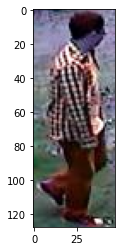

In [31]:
import glob
import cv2
import matplotlib.pyplot as plt
a = query_path[-1]
print(a)
for frame in sorted(glob.glob(a[0])):
  img = cv2.imread(frame)
  plt.imshow(img)
  plt.show()
  query = concatenated_query_vectors[0]

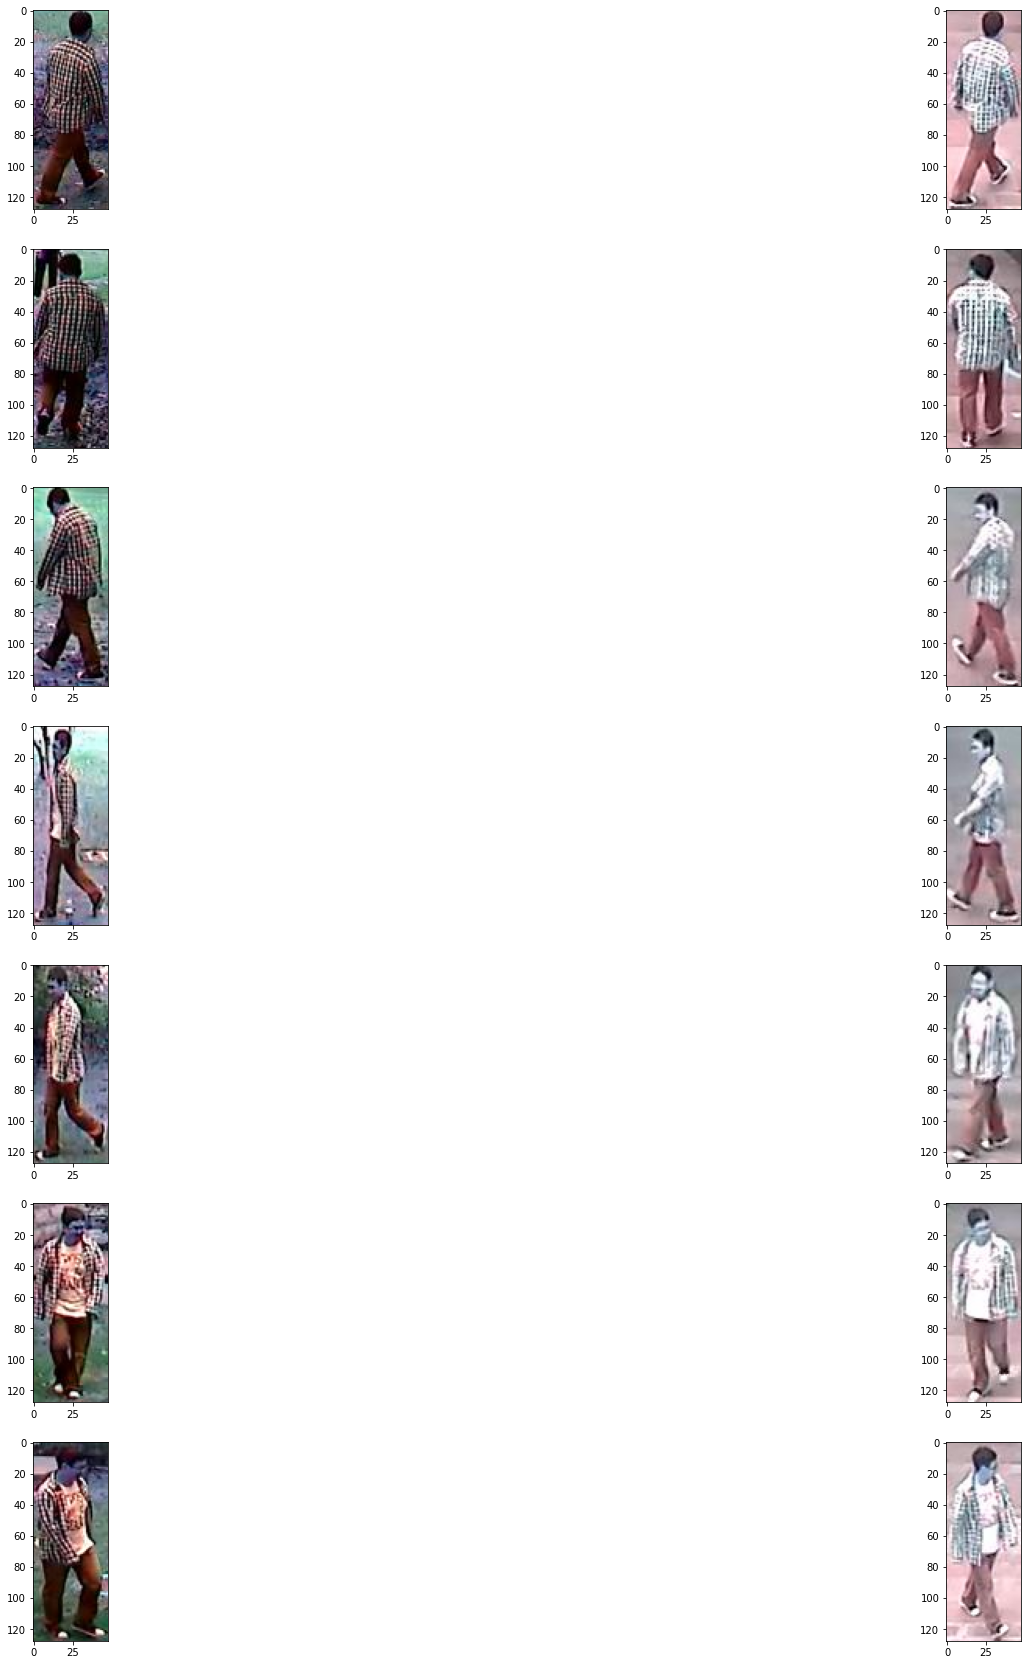

In [28]:
fig, axs = plt.subplots(7,2,figsize=(30,30))
for i in range(2,9):
  path = "/content/reid-col780-master/data/val/gallery/"
  p1 = path + "088/01_"+str(i)+".png" 
  p2 = path + "088/02_"+str(i)+".png"
  img1 = cv2.imread(p1)
  img2 = cv2.imread(p2)
  # print(p1)
  axs[i-2,0].imshow(img1)
  # print(p2)
  axs[i-2,1].imshow(img2)